# IEDB Query API (IQ-API) - Use Case 1G
**Goal**: Search for information related to a branch of the NCBI taxonomy, using Dengue virus and all Flaviviruses as examples.

The goal of this use case is to query for epitopes arising from a single branch of the NCBI taxonomy.  For example, extracting all viral epitopes or extracting all epitopes related to Dengue virus.  The approach outlined here can be applied to all tables where the *source_organism_iri_search* field exists.

For more information on the expressive syntax of PostgresT, refer to [this document](https://postgrest.org/en/stable/api.html#).  For more details on the tables that are part of the API, refer to [the swagger documetation](http://query-api.iedb.org/docs/swagger/).

---

First, let's import required modules, set some globals, and define a function to print the corresponding CURL command for each request.  I've tried to include that CURL command for each example so that you can copy/paste it into your terminal.  You may want to pipe the output to a tool like 'jq' to have it render neatly.

In [10]:
import requests
import json
import time
import pandas as pd
from io import StringIO

base_uri='https://query-api.iedb.org'

# funciton to print the CURL command given a request
def print_curl_cmd(req):
    url = req.url
    print("curl -X 'GET' '" + url + "'")

This may or may not have resulted in a warning about lzma compression.  That can be safely ignored...

## The IRI search fields

Before we get started, we need to understand the fields that have 'iri_search' in their names.  For example, *source_organism_iri_search* or *host_organism_iri_search*.  All organism-related fields in the IEDB make use of the [NCBI Taxonomomy](https://www.ncbi.nlm.nih.gov/taxonomy) and reference the organism in question with its NCBI Taxonomy ID prefaced by the string 'NCBITaxon'.  For example, Dengue virus has the [NCBI Taxonomy ID 12637](https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?mode=Info&id=12637) and would be referenced as 'NCBITaxon:12637'.  In the context of the NCBI Taxonomy, it's position looks like:

```
Organism (NCBITaxon:1)
  Viruses (NCBITaxon:10239)
    Riboviria (NCBITaxon:2559587)
      Orthornavirae (NCBITaxon:2732396)
        Kitrinoviricota (NCBITaxon:2732406)
          Flasuviricetes (NCBITaxon:2732462)
            Amarillovirales (NCBITaxon:2732545)
              Flaviviridae (NCBITaxon:11050)
                Orthoflavivirus (NCBITaxon:3044782)
                  Orthoflavivirus denguei (NCBITaxon:3052464)
                    Dengue virus (NCBITaxon:12637)
```

In order to be able to make use of this hierarchy, the organsim taxonomy ID as well **many of its ancestor taxonomy IDs** are encoded into these *organism_iri_search* fields.  The *source_organism_iri_search* field of (https://query-api.iedb.org/epitope_search?structure_id=eq.19121&select=structure_id,source_organism_names,source_organism_iris,source_organism_iri_search)[this epitope record from a Dengue virus 2 strain] looks like:

```json
"source_organism_iri_search": [
"NCBITaxon:1",
"NCBITaxon:10239",
"NCBITaxon:11050",
"NCBITaxon:11060",
"NCBITaxon:11064",
"NCBITaxon:12637",
"NCBITaxon:3044782",
"OBI:0100026"
]
```

Note that there are several intermediate taxonomy IDs that are missing, skipping the taxonomy IDs in between Viruses (superkingdom) and Flaviviridae (family) levels as well as the 'Orthoflavivirus denguei' level.  You will also note an additional entry for [OBI:0100026](http://purl.obolibrary.org/obo/OBI_0100026), which corresponds to the 'organism' term in the [Ontology of Biomedical Investigations (OBI)](http://obi-ontology.org/).

Other *iri_search* fields exist with values from taxonomies other than the NCBI.  For example:

* *mhc_allele_iri_search* encodes values from the [MHC Restriction Ontology](http://www.obofoundry.org/ontology/mro.html)
* *disease_iri_search* uses the [Human Disease Ontology](http://www.obofoundry.org/ontology/doid.html)

The above list is not exhaustive.  For a detailed list of ontologies employed an the CURIEs used to refer to them, please consule the [curie_map](https://query-api.iedb.org/curie_map) table.


## Query for Dengue epitopes

So, in order to compose a query for all records below the 'Dengue virus' node in the taxonomy, all that is needed is to query on the *source_organism_iri_search* field for the presence of 'NCBITaxon:12637'.  Since this field is an array, we will need to use the [cs operator](https://postgrest.org/en/stable/api.html#operators) for 'contains'.  We also restrict the output to the small subset of fields that are relevant to our search with the [select operator](https://postgrest.org/en/stable/api.html#vertical-filtering-columns):


In [11]:
search_params={ 'source_organism_iri_search': 'cs.{"NCBITaxon:12637"}',
                'select': 'structure_iri,structure_description,curated_source_antigens,iedb_assay_ids,qualitative_measures,source_organism_names,source_organism_names,source_organism_iri_search',
                'order': 'structure_iri',
              }
table_name='epitope_search'
full_url=base_uri + '/' + table_name
result = requests.get(full_url, params=search_params)
print_curl_cmd(result)

curl -X 'GET' 'https://query-api.iedb.org/epitope_search?source_organism_iri_search=cs.%7B%22NCBITaxon%3A12637%22%7D&select=structure_iri%2Cstructure_description%2Ccurated_source_antigens%2Ciedb_assay_ids%2Cqualitative_measures%2Csource_organism_names%2Csource_organism_names%2Csource_organism_iri_search&order=structure_iri'


OK we have the result...now let's have a look.  **Note**: We are only printing the first record here to get a sense of what is returned.

In [12]:
print(json.dumps(result.json()[:1], indent=4))

[
    {
        "structure_iri": "IEDB_EPITOPE:100978",
        "structure_description": "KIEKASFIEVKSCHW",
        "curated_source_antigens": [
            {
                "accession": "CAA78918.1",
                "name": "NS1",
                "iri": "GENPEPT:CAA78918.1",
                "starting_position": 239,
                "ending_position": 253,
                "source_organism_name": "Dengue virus",
                "source_organism_iri": "NCBITaxon:12637"
            }
        ],
        "iedb_assay_ids": [
            1619828
        ],
        "qualitative_measures": [
            "Negative"
        ],
        "source_organism_names": [
            "Dengue virus"
        ],
        "source_organism_iri_search": [
            "NCBITaxon:1",
            "NCBITaxon:10239",
            "NCBITaxon:11050",
            "NCBITaxon:12637",
            "NCBITaxon:3044782",
            "OBI:0100026"
        ]
    }
]


We can also load the output into a data frame.

In [13]:
df = pd.json_normalize(result.json())
df

,structure_iri,structure_description,curated_source_antigens,iedb_assay_ids,qualitative_measures,source_organism_names,source_organism_iri_search
0,IEDB_EPITOPE:100978,KIEKASFIEVKSCHW,"[{'accession': 'CAA78918.1', 'name': 'NS1', 'i...",[1619828],[Negative],[Dengue virus],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
1,IEDB_EPITOPE:10124,DSGCVVSWK,"[{'accession': 'CAA78918.1', 'name': 'NS1', 'i...","[1480241, 1480242]",[Positive-High],[Dengue virus 2 Puerto Rico/PR159-S1/1969 (Den...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
2,IEDB_EPITOPE:10125,DSGCVVSWKNKELKC,"[{'accession': 'AAA42941.1', 'name': 'viral po...","[22048, 22049, 22050, 22053, 22632, 22633, 572...","[Negative, Positive]","[Dengue virus, Dengue virus 2 New Guinea C, de...","[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3,IEDB_EPITOPE:101410,WCCRSCTLPPLRYRGEDGCW,"[{'accession': '1802191G', 'name': 'nonstructu...","[1619824, 2445250, 2445251]",[Positive],"[Dengue virus, dengue virus type 2 (Dengue Vir...","[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
4,IEDB_EPITOPE:102102,SYSMCTGKFKVV,"[{'accession': 'AAM75194.1', 'name': 'envelope...","[1620787, 1620789, 1620790, 1620791, 1620792, ...",[Positive],[dengue virus type 2 (Dengue Virus serotype 2)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
...,...,...,...,...,...,...,...
9995,IEDB_EPITOPE:196274,"R353, G358, E359","[{'accession': 'AAB69126.2', 'name': 'polyprot...",[2021405],[Positive],[dengue virus type 3 (Dengue virus serotype 3)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
9996,IEDB_EPITOPE:196275,"W381, G389","[{'accession': 'AAB69126.2', 'name': 'polyprot...","[2021508, 2021510]",[Positive],[dengue virus type 3 (Dengue virus serotype 3)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
9997,IEDB_EPITOPE:196276,"W381, G391","[{'accession': 'AAB69126.2', 'name': 'polyprot...",[2021458],[Positive],[dengue virus type 3 (Dengue virus serotype 3)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
9998,IEDB_EPITOPE:196277,"W381, L387, F388, G391","[{'accession': 'AAB69126.2', 'name': 'polyprot...",[2021460],[Positive],[dengue virus type 3 (Dengue virus serotype 3)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."


So it looks as though exactly 10,000 records were returned.  This should raise suspicion as 10,000 is the default limit for a 'page' of results.  If you receive 10,000 results it indicates that you are only getting the first page back and you will need to pull the rest of the results in subsequent calls.  This is described further in the [IQ-API help material](https://help.iedb.org/hc/en-us/articles/4402872882189).

### Retrieving more than 10,000 records

We will need to retrieve the rest of the records by increasing the 'offset' parameter until we have pulled the complete dataset.  **WARNING:** Whenever requesting a result with multiple pages, **it is *essential* to add an 'order' keyword**.  Without it, the pages may be inconsistent between calls.

We also add a pause of 2 seconds between calls in order to be a good citizen:

In [14]:
search_params['offset'] = 0
while result.json() != []:
    time.sleep(2)
    search_params['offset'] += 10000
    print('offset: ' + str(search_params['offset']))
    result = requests.get(full_url, params=search_params)
    df = df.append(pd.json_normalize(result.json()))
print('Done!')

offset: 10000
offset: 20000
Done!


Let's take another look at our data frame, now that it's complete.

In [15]:
df

,structure_iri,structure_description,curated_source_antigens,iedb_assay_ids,qualitative_measures,source_organism_names,source_organism_iri_search
0,IEDB_EPITOPE:100978,KIEKASFIEVKSCHW,"[{'accession': 'CAA78918.1', 'name': 'NS1', 'i...",[1619828],[Negative],[Dengue virus],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
1,IEDB_EPITOPE:10124,DSGCVVSWK,"[{'accession': 'CAA78918.1', 'name': 'NS1', 'i...","[1480241, 1480242]",[Positive-High],[Dengue virus 2 Puerto Rico/PR159-S1/1969 (Den...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
2,IEDB_EPITOPE:10125,DSGCVVSWKNKELKC,"[{'accession': 'AAA42941.1', 'name': 'viral po...","[22048, 22049, 22050, 22053, 22632, 22633, 572...","[Negative, Positive]","[Dengue virus, Dengue virus 2 New Guinea C, de...","[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3,IEDB_EPITOPE:101410,WCCRSCTLPPLRYRGEDGCW,"[{'accession': '1802191G', 'name': 'nonstructu...","[1619824, 2445250, 2445251]",[Positive],"[Dengue virus, dengue virus type 2 (Dengue Vir...","[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
4,IEDB_EPITOPE:102102,SYSMCTGKFKVV,"[{'accession': 'AAM75194.1', 'name': 'envelope...","[1620787, 1620789, 1620790, 1620791, 1620792, ...",[Positive],[dengue virus type 2 (Dengue Virus serotype 2)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
...,...,...,...,...,...,...,...
3818,IEDB_EPITOPE:9682,DPMALKDFK,"[{'accession': 'P09866.2', 'name': 'Genome pol...","[14792, 14794]","[Negative, Positive]",[dengue virus type 4 (dengue type 4 virus DEN4)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3819,IEDB_EPITOPE:969058,KLKEKQDVFCDSKL,"[{'accession': 'AAD11533.1', 'name': 'NS1, par...",[6478129],[Positive],[dengue virus type 2 (Dengue Virus serotype 2)],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3820,IEDB_EPITOPE:970,AEHTGREI,"[{'accession': 'NP_739587.1', 'name': 'NS3 pro...","[22594, 22595, 22596, 22597, 22598, 22599, 226...",[Positive],[Dengue virus 2 16681-PDK53 (Dengue virus type...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3821,IEDB_EPITOPE:9978,DRGWGN,"[{'accession': 'AAS49691.2', 'name': 'envelope...",[1380221],[Positive],[Dengue virus 2 Jamaica/1409/1983 (Dengue viru...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."


Looks like there are 13,823 Dengue epitope records, which matches what we obtain through the web interface as of November 3, 2023:

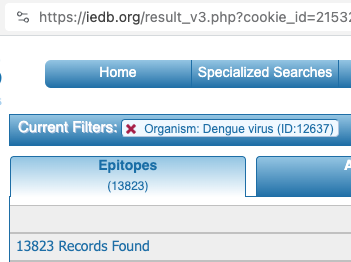

## Query for Orthoflavivirus epitopes

**NOTE**: In previous versions, we searched for Flavivirus.  However, the NCBI taxonomy has undergone a widespread reorganization, which moved Dengue virus underneath Orthoflavivirus (a sibling of Flavivirus).

What if we want to now search a level or two higher in the taxonomy, for epitopes from all of Orthoflavivirus?  Simply update our query to use the NCBI Taxonomy ID of Orthoflavivirus in the *source_organism_iri_search* field and repeat:

In [16]:
search_params={ 'source_organism_iri_search': 'cs.{"NCBITaxon:3044782"}',
                'select': 'structure_iri,structure_description,curated_source_antigens,iedb_assay_ids,qualitative_measures,source_organism_names,source_organism_names,source_organism_iri_search',
                'offset': 0,
                'order': 'structure_iri'
              }
table_name='epitope_search'
full_url=base_uri + '/' + table_name

# get the first 10K results and load them into a data frame
result = requests.get(full_url, params=search_params)
df_flavi = pd.json_normalize(result.json())

while result.json() != []:
    time.sleep(2)
    search_params['offset'] += 10000
    print('offset: ' + str(search_params['offset']))
    result = requests.get(full_url, params=search_params)
    df_flavi = df_flavi.append(pd.json_normalize(result.json()))
print('Done!')

df_flavi

offset: 10000
offset: 20000
offset: 30000
Done!


,structure_iri,structure_description,curated_source_antigens,iedb_assay_ids,qualitative_measures,source_organism_names,source_organism_iri_search
0,IEDB_EPITOPE:10047,DRRWCFDGPRTNTIL,"[{'accession': 'AAF20092.2', 'name': 'polyprot...","[1556567, 1964057, 1966001, 1966002, 1966003, ...","[Negative, Positive]",[West Nile virus],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
1,IEDB_EPITOPE:10052,DRSIALTFLAVGGVL,"[{'accession': 'AAK62756.1', 'name': 'envelope...","[1021156, 1021157, 1021158, 1021159, 1021160, ...","[Negative, Positive-High, Positive-Low]",[West Nile virus],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
2,IEDB_EPITOPE:100788,DNNEVEVITKLGERK,"[{'accession': 'YP_001527884.1', 'name': 'nons...",[1606244],[Positive-Low],[West Nile virus],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3,IEDB_EPITOPE:10088,DSDDWLNKY,"[{'accession': 'NP_041726.1', 'name': 'polypro...","[1407360, 1457573, 1940224, 2145691, 2147472, ...","[Negative, Positive, Positive-High, Positive-I...",[Yellow fever virus 17D (Yellow fever virus (S...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
4,IEDB_EPITOPE:100938,IFVHGPTTVESHGNY,"[{'accession': 'AGX89731.1', 'name': 'polyprot...","[1606239, 6554092]","[Positive, Positive-Low]","[West Nile virus, West Nile virus goshawk/Aust...","[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
...,...,...,...,...,...,...,...
3415,IEDB_EPITOPE:996940,YLASVSDLSTRAACP,"[{'accession': 'AGX89731.1', 'name': 'polyprot...",[6554072],[Negative],[West Nile virus goshawk/Austria/2008],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3416,IEDB_EPITOPE:996962,YTGTDGPCKVPISSV,"[{'accession': 'AGX89731.1', 'name': 'polyprot...",[6554139],[Negative],[West Nile virus goshawk/Austria/2008],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3417,IEDB_EPITOPE:996983,YYVMSVGAKSFLVHR,"[{'accession': 'AGX89731.1', 'name': 'polyprot...",[6554107],[Positive],[West Nile virus goshawk/Austria/2008],"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."
3418,IEDB_EPITOPE:9978,DRGWGN,"[{'accession': 'AAS49691.2', 'name': 'envelope...",[1380221],[Positive],[Dengue virus 2 Jamaica/1409/1983 (Dengue viru...,"[NCBITaxon:1, NCBITaxon:10239, NCBITaxon:11050..."


OK now we have 23,420 epitopes, which should include all of the Dengue epitopes.

## Limiting the results to T cell epitopes

What if we want to limit the output to peptides that were positive in at least one T cell assay (i.e., T cell epitopes).  We can perform essentiallly the same search against the **tcell_search** table, restricting it only to assays that do not have 'Negative' as their qualitative value.

In [17]:
search_params={ 'source_organism_iri_search': 'cs.{"NCBITaxon:3044782"}',
                'select': 'tcell_iri,structure_iri,linear_sequence,curated_source_antigen,qualitative_measure,assay_names,source_organism_name,source_organism_name',
                'qualitative_measure': 'not.eq.Negative',
                'offset': 0,
                'order': 'tcell_iri'
              }
table_name='tcell_search'
full_url=base_uri + '/' + table_name

# get the first 10K results and load them into a data frame
result = requests.get(full_url, params=search_params)
df_tcell = pd.json_normalize(result.json())

while result.json() != []:
    time.sleep(2)
    search_params['offset'] += 10000
    print('offset: ' + str(search_params['offset']))
    result = requests.get(full_url, params=search_params)
    df_tcell = df_tcell.append(pd.json_normalize(result.json()))
print('Done!')

df_tcell



offset: 10000
offset: 20000
Done!


,tcell_iri,structure_iri,linear_sequence,qualitative_measure,assay_names,source_organism_name,curated_source_antigen.accession,curated_source_antigen.name,curated_source_antigen.iri,curated_source_antigen.starting_position,curated_source_antigen.ending_position,curated_source_antigen.source_organism_name,curated_source_antigen.source_organism_iri
0,IEDB_ASSAY:10011,IEDB_EPITOPE:53867,RGFRKEIGRMLNILNRRRS,Positive,IFNg release|ELISPOT,Dengue virus 2 Thailand/16681/84 (Dengue virus...,SRC265914,Genome polyprotein,ONTIE:0002377,NaN,NaN,Dengue virus 2 Thailand/16681/84 (Dengue virus...,NCBITaxon:31634
1,IEDB_ASSAY:10014,IEDB_EPITOPE:31511,KKDQVVVLGSQEGAM,Positive,IFNg release|ELISPOT,Dengue virus 2 Thailand/16681/84 (Dengue virus...,SRC265914,Genome polyprotein,ONTIE:0002377,NaN,NaN,Dengue virus 2 Thailand/16681/84 (Dengue virus...,NCBITaxon:31634
2,IEDB_ASSAY:10031,IEDB_EPITOPE:7384,CYHASVTDI,Positive,cytotoxicity|51 chromium,Japanese encephalitis virus strain Nakayama (J...,AAK31640.1,envelope protein,GENPEPT:AAK31640.1,60.0,68.0,Japanese encephalitis virus strain Nakayama (J...,NCBITaxon:11076
3,IEDB_ASSAY:10032,IEDB_EPITOPE:7384,CYHASVTDI,Positive,cytotoxicity|51 chromium,Japanese encephalitis virus strain Nakayama (J...,AAK31640.1,envelope protein,GENPEPT:AAK31640.1,60.0,68.0,Japanese encephalitis virus strain Nakayama (J...,NCBITaxon:11076
4,IEDB_ASSAY:10143,IEDB_EPITOPE:3124,AMKGLPIRY,Positive,cytotoxicity|51 chromium,Dengue virus type 3 CH53489,P27915.1,Genome polyprotein,GENPEPT:P27915.1,1708.0,1716.0,Dengue virus type 3 CH53489,ONTIE:0000351
...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,IEDB_ASSAY:9559,IEDB_EPITOPE:62183,SVKKDLISY,Positive,proliferation|3H-thymidine,dengue virus type 3 (Dengue virus serotype 3),YP_001531172.2,Nonstructural protein NS3,GENPEPT:YP_001531172.2,71.0,79.0,dengue virus type 3 (Dengue virus serotype 3),NCBITaxon:11069
802,IEDB_ASSAY:9620,IEDB_EPITOPE:7995,DEGEGRVI,Positive,cytotoxicity|51 chromium,Murray valley encephalitis virus (strain MVE-1...,NP_722535.1,NS3,GENPEPT:NP_722535.1,436.0,443.0,Murray valley encephalitis virus (strain MVE-1...,NCBITaxon:301478
803,IEDB_ASSAY:9621,IEDB_EPITOPE:53523,REHSGNEI,Positive,cytotoxicity|51 chromium,Murray valley encephalitis virus (strain MVE-1...,NP_722535.1,NS3,GENPEPT:NP_722535.1,250.0,257.0,Murray valley encephalitis virus (strain MVE-1...,NCBITaxon:301478
804,IEDB_ASSAY:9921,IEDB_EPITOPE:27061,ILGDTAWDFG,Positive,IFNg release|ELISPOT,Dengue virus 2 Thailand/16681/84 (Dengue virus...,ABU89742.1,envelope glycoprotein,GENPEPT:ABU89742.1,96.0,105.0,Dengue virus 2 Thailand/16681/84 (Dengue virus...,NCBITaxon:31634


10,806 positive T cell assays for Orthoflavivirus.  That matches the web results for the IEDB as of November 3, 2023:

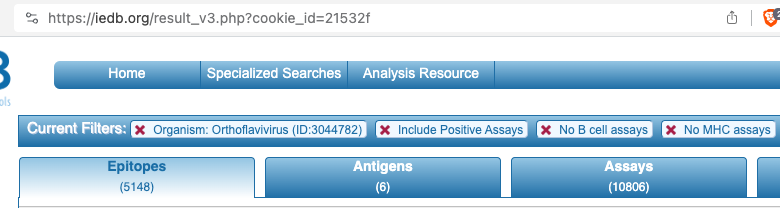

Note, however, that since we queried against the T cell table, the rows are unique by assay rather than epitope. So we will need to extract the unique epitopes.

In [18]:
df_tcell.drop_duplicates(subset = ['linear_sequence'])

,tcell_iri,structure_iri,linear_sequence,qualitative_measure,assay_names,source_organism_name,curated_source_antigen.accession,curated_source_antigen.name,curated_source_antigen.iri,curated_source_antigen.starting_position,curated_source_antigen.ending_position,curated_source_antigen.source_organism_name,curated_source_antigen.source_organism_iri
0,IEDB_ASSAY:10011,IEDB_EPITOPE:53867,RGFRKEIGRMLNILNRRRS,Positive,IFNg release|ELISPOT,Dengue virus 2 Thailand/16681/84 (Dengue virus...,SRC265914,Genome polyprotein,ONTIE:0002377,NaN,NaN,Dengue virus 2 Thailand/16681/84 (Dengue virus...,NCBITaxon:31634
1,IEDB_ASSAY:10014,IEDB_EPITOPE:31511,KKDQVVVLGSQEGAM,Positive,IFNg release|ELISPOT,Dengue virus 2 Thailand/16681/84 (Dengue virus...,SRC265914,Genome polyprotein,ONTIE:0002377,NaN,NaN,Dengue virus 2 Thailand/16681/84 (Dengue virus...,NCBITaxon:31634
2,IEDB_ASSAY:10031,IEDB_EPITOPE:7384,CYHASVTDI,Positive,cytotoxicity|51 chromium,Japanese encephalitis virus strain Nakayama (J...,AAK31640.1,envelope protein,GENPEPT:AAK31640.1,60.0,68.0,Japanese encephalitis virus strain Nakayama (J...,NCBITaxon:11076
4,IEDB_ASSAY:10143,IEDB_EPITOPE:3124,AMKGLPIRY,Positive,cytotoxicity|51 chromium,Dengue virus type 3 CH53489,P27915.1,Genome polyprotein,GENPEPT:P27915.1,1708.0,1716.0,Dengue virus type 3 CH53489,ONTIE:0000351
5,IEDB_ASSAY:10145,IEDB_EPITOPE:2859,ALRGLPIRY,Positive,cytotoxicity|51 chromium,Dengue virus 2 Thailand/NGS-C/1944 (Dengue vir...,NP_739587.1,NS3 protein,GENPEPT:NP_739587.1,234.0,242.0,Dengue virus 2 Thailand/NGS-C/1944 (Dengue vir...,NCBITaxon:11065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,IEDB_ASSAY:7685168,IEDB_EPITOPE:1066541,ACLAKSYAQMWLLLY,Positive-Low,IFNg release|ELISPOT,West Nile virus,Q8JU42.1,Genome polyprotein,UNIPROT:Q8JU42.1,3285.0,3299.0,West Nile virus,NCBITaxon:11082
749,IEDB_ASSAY:7685171,IEDB_EPITOPE:1067634,LKRGMPRVLSLIGLK,Positive-Low,IFNg release|ELISPOT,West Nile virus,Q9Q6P4.2,Genome polyprotein,UNIPROT:Q9Q6P4.2,17.0,31.0,West Nile virus,NCBITaxon:11082
779,IEDB_ASSAY:8025,IEDB_EPITOPE:19434,GESRKTFVE,Positive,cytotoxicity|51 chromium,dengue virus type 3 (Dengue virus serotype 3),P27915.1,Genome polyprotein,GENPEPT:P27915.1,2001.0,2009.0,dengue virus type 3 (Dengue virus serotype 3),NCBITaxon:11069
785,IEDB_ASSAY:8271173,IEDB_EPITOPE:230626,AMTDTTPFGQQRVFK,Positive,IFNg release|ELISPOT,Dengue virus,AQV12160.1,polyprotein [Dengue virus],GENPEPT:AQV12160.1,2834.0,2848.0,Dengue virus,NCBITaxon:12637


5,148 sequences from Flavivirus that were positive in at least 1 T cell assay, which matches the current data in the IEDB.

### An alternative approach using resource embeddings

**NOTE:**  This example takes a few minutes to run, likely due to inefficient joins.

We can also make use of [resource embeddings](https://postgrest.org/en/stable/api.html#resource-embedding) to get at this same information.  Here, we start with the epitope_search table, limit it to those with tcell_ids, then join it to the tcell_search table where the qualitative value is not 'Negative'.  Since results are returned for ALL epitope records with T cell assays, they need to be further processed to remove the epitopes without associated 'positive' T cell records.

In [19]:
search_params={ 'source_organism_iri_search': 'cs.{"NCBITaxon:3044782"}',
                'tcell_ids': 'not.is.null',
                'tcell_search.qualitative_measure': 'not.eq.Negative',
                'select': 'structure_id,tcell_ids,tcell_search(tcell_iri,qualitative_measure)',
                'offset': 0,
                'order': 'structure_id'
              }
table_name='epitope_search'
full_url=base_uri + '/' + table_name

# get the first 10K results and load them into a data frame
result = requests.get(full_url, params=search_params)
df_tcell_from_epitope = pd.json_normalize(result.json())

while result.json() != []:
    time.sleep(2)
    search_params['offset'] += 10000
    print('offset: ' + str(search_params['offset']))
    result = requests.get(full_url, params=search_params)
    df_tcell_from_epitope = df_tcell_from_epitope.append(pd.json_normalize(result.json()))
print('Done!')

df_tcell_from_epitope


offset: 10000
offset: 20000
Done!


,structure_id,tcell_ids,tcell_search
0,39,"[1276254, 2724561, 3135713, 3135714]","[{'tcell_iri': 'IEDB_ASSAY:3135713', 'qualitat..."
1,89,"[1211071, 1211083, 1211108]","[{'tcell_iri': 'IEDB_ASSAY:1211083', 'qualitat..."
2,90,"[1211072, 1211093, 1211109]","[{'tcell_iri': 'IEDB_ASSAY:1211093', 'qualitat..."
3,113,[1276237],[]
4,394,"[1556522, 1964046, 1965417, 1965946, 1965947, ...","[{'tcell_iri': 'IEDB_ASSAY:1556522', 'qualitat..."
...,...,...,...
868,2151439,"[22255558, 22255559, 22255560, 22255561]","[{'tcell_iri': 'IEDB_ASSAY:22255558', 'qualita..."
869,2151440,[22255444],"[{'tcell_iri': 'IEDB_ASSAY:22255444', 'qualita..."
870,2151442,"[22255649, 22255650, 22255651]","[{'tcell_iri': 'IEDB_ASSAY:22255649', 'qualita..."
871,2151443,[22255615],"[{'tcell_iri': 'IEDB_ASSAY:22255615', 'qualita..."


Now we filter out all of the rows where no corresponding, positive T cell assays were found.

In [20]:
df_tcell_from_epitope[df_tcell_from_epitope['tcell_search'].apply(lambda x : len(x) > 0)]

,structure_id,tcell_ids,tcell_search
0,39,"[1276254, 2724561, 3135713, 3135714]","[{'tcell_iri': 'IEDB_ASSAY:3135713', 'qualitat..."
1,89,"[1211071, 1211083, 1211108]","[{'tcell_iri': 'IEDB_ASSAY:1211083', 'qualitat..."
2,90,"[1211072, 1211093, 1211109]","[{'tcell_iri': 'IEDB_ASSAY:1211093', 'qualitat..."
4,394,"[1556522, 1964046, 1965417, 1965946, 1965947, ...","[{'tcell_iri': 'IEDB_ASSAY:1556522', 'qualitat..."
6,645,"[1497597, 1497748, 1972604, 3468741]","[{'tcell_iri': 'IEDB_ASSAY:1972604', 'qualitat..."
...,...,...,...
868,2151439,"[22255558, 22255559, 22255560, 22255561]","[{'tcell_iri': 'IEDB_ASSAY:22255558', 'qualita..."
869,2151440,[22255444],"[{'tcell_iri': 'IEDB_ASSAY:22255444', 'qualita..."
870,2151442,"[22255649, 22255650, 22255651]","[{'tcell_iri': 'IEDB_ASSAY:22255649', 'qualita..."
871,2151443,[22255615],"[{'tcell_iri': 'IEDB_ASSAY:22255615', 'qualita..."


And we get 5,148!